In [1]:
import sympy
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import dill
from tqdm import tqdm
from triangle import triangulate, plot
from random import sample
from utils import (
    get_middle_indices,
    get_delta_function,
    orient,
    combine_arguments,
    fill_stiffness_matrix,
)
from utils import G1_hat, G2_hat, G3_hat, rot
from matplotlib import cm

dill.settings["recurse"] = True

### Get precomputed integrals

In [2]:
biharmonic_functional = dill.load(
    open("../calculations/argyris_quintic_biharmonic_matrix_with_mixed", "rb")
)
basis_integral_values = dill.load(
    open("../calculations/argyris_quintic_biharmonic_matrix_right_values", "rb")
)

### Initialize the domain

In [3]:
t = np.linspace(0, 2 * np.pi, 100, endpoint=False)
points = np.stack((np.cos(t), np.sin(t))).T

seg = np.array(
    [[j, j + 1] for j in range(points.shape[0] - 1)] + [[points.shape[0] - 1, 0]]
)

### Run triangulation

In [4]:
cndt = triangulate({"vertices": points, "segments": seg}, opts="pq30a0.1neo2s")
points = cndt["vertices"]
triangles = cndt["triangles"]
neighbours = cndt["neighbors"]
edges = cndt["edges"]
vertex_marker_is_boundary = cndt["vertex_markers"]
edge_marker_is_boundary = cndt["edge_markers"]
print(
    f"Total number of points:\t\t{points.shape[0]}\nTotal number of elements:\t{triangles.shape[0]}"
)

Total number of points:		925
Total number of elements:	412


### Separate middles

In [5]:
is_middle = get_middle_indices(points.shape[0], triangles)

### Visualize triangulation

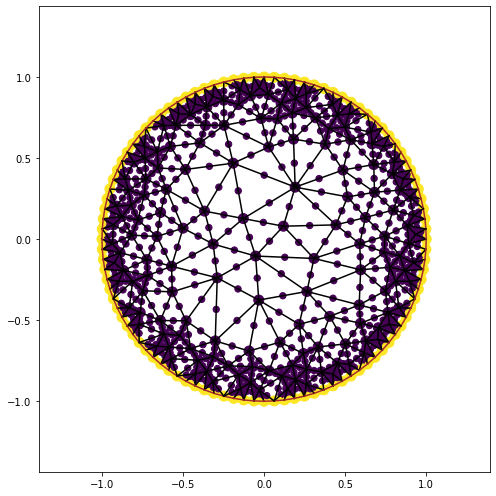

In [6]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(7, 7))
ax.axis("equal")

cl = ["black", "brown"]

for eidx, edge in enumerate(edges):
    ax.plot(
        points[edge][:, 0],
        points[edge][:, 1],
        color=cl[edge_marker_is_boundary[eidx][0]],
    )

ax.scatter(*points.T, c=vertex_marker_is_boundary, s=100 - is_middle.astype(int) * 60)

ax.set_xlim([points[:, 0].min() - 1 / 2, points[:, 0].max() + 1 / 2])
ax.set_ylim([points[:, 1].min() - 1 / 2, points[:, 1].max() + 1 / 2])

fig.tight_layout()
plt.tight_layout()

plt.show()

### Initialize variables

In [7]:
total_points = points.shape[0]
num_midpoints = is_middle.sum()
num_nodes = total_points - num_midpoints
NUM = 6 * num_nodes + num_midpoints

In [8]:
x, y = sympy.symbols("x y")

### Define the right part of the equation

In [9]:
F = sympy.Float(1)
F_x = F.diff(x)
F_y = F.diff(y)
F_xx = F_x.diff(x)
F_xy = F_x.diff(y)
F_yy = F_y.diff(y)

In [10]:
right_part_values = np.zeros((total_points, 6))
right_part_values[:, 0] = sympy.lambdify((x, y), F)(*points.T)
right_part_values[:, 1] = sympy.lambdify((x, y), F_x)(*points.T)
right_part_values[:, 2] = sympy.lambdify((x, y), F_y)(*points.T)
right_part_values[:, 3] = sympy.lambdify((x, y), F_xx)(*points.T)
right_part_values[:, 4] = sympy.lambdify((x, y), F_xy)(*points.T)
right_part_values[:, 5] = sympy.lambdify((x, y), F_yy)(*points.T)

### Stiffnes matrix assembling

In [11]:
matrix = np.zeros((NUM, NUM))
b = np.zeros((NUM))

for idx, element in enumerate(tqdm(triangles)):
    element = orient(element)
    arguments = combine_arguments(points, element, right_part_values)
    bilinear_form = biharmonic_functional(*arguments)
    right_part = basis_integral_values(*arguments)
    fill_stiffness_matrix(
        matrix,
        b,
        bilinear_form,
        right_part,
        element,
        vertex_marker_is_boundary,
        num_nodes,
    )

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 412/412 [00:57<00:00,  7.19it/s]


### Visualize stiffness matrix

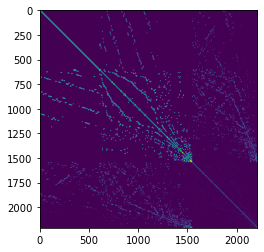

In [12]:
fig, ax = plt.subplots()
ax.imshow(matrix != 0)
plt.show()

### Solve the system

In [13]:
c = np.linalg.solve(matrix, b)

### Get values

In [14]:
U = (1 - x**2 - y**2) ** 2 / 64
U_x = sympy.lambdify((x, y), U.diff(x))(*points.T[:, :num_nodes])
U_y = sympy.lambdify((x, y), U.diff(y))(*points.T[:, :num_nodes])
U_xx = sympy.lambdify((x, y), U.diff(x, x))(*points.T[:, :num_nodes])
U_xy = sympy.lambdify((x, y), U.diff(x, y))(*points.T[:, :num_nodes])
U_yy = sympy.lambdify((x, y), U.diff(y, y))(*points.T[:, :num_nodes])
U = sympy.lambdify((x, y), U)(*points.T[:, :num_nodes])
_x_ = points[:num_nodes, 0]
_y_ = points[:num_nodes, 1]
F = c[0 : (6 * num_nodes) : 6]
Fx = c[1 : (6 * num_nodes) : 6]
Fy = c[2 : (6 * num_nodes) : 6]
Fxx = c[3 : (6 * num_nodes) : 6]
Fxy = c[4 : (6 * num_nodes) : 6]
Fyy = c[5 : (6 * num_nodes) : 6]

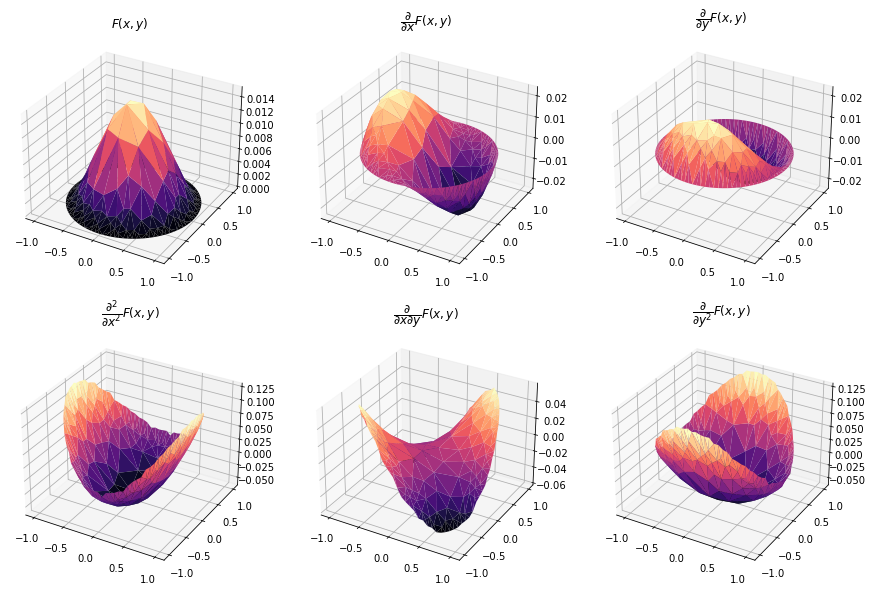

In [15]:
%matplotlib widget
fig, ax = plt.subplots(2, 3, figsize=(15, 10), subplot_kw=dict(projection="3d"))
plot_1 = ax[0, 0].plot_trisurf(_x_, _y_, F, triangles=triangles[:, :3], cmap=cm.magma)
ax[0, 0].set_title(r"$F\left(x, y\right)$")
plot_2 = ax[0, 1].plot_trisurf(_x_, _y_, Fx, triangles=triangles[:, :3], cmap=cm.magma)
ax[0, 1].set_title(r"$\dfrac{\partial}{\partial x}F\left(x, y\right)$")
plot_3 = ax[0, 2].plot_trisurf(_x_, _y_, Fy, triangles=triangles[:, :3], cmap=cm.magma)
ax[0, 2].set_title(r"$\dfrac{\partial}{\partial y}F\left(x, y\right)$")
plot_4 = ax[1, 0].plot_trisurf(_x_, _y_, Fxx, triangles=triangles[:, :3], cmap=cm.magma)
ax[1, 0].set_title(r"$\dfrac{\partial^{2}}{\partial x^{2}}F\left(x, y\right)$")
plot_5 = ax[1, 1].plot_trisurf(_x_, _y_, Fxy, triangles=triangles[:, :3], cmap=cm.magma)
ax[1, 1].set_title(r"$\dfrac{\partial}{\partial x \partial y}F\left(x, y\right)$")
plot_6 = ax[1, 2].plot_trisurf(_x_, _y_, Fyy, triangles=triangles[:, :3], cmap=cm.magma)
ax[1, 2].set_title(r"$\dfrac{\partial}{\partial y^{2}}F\left(x, y\right)$")
plt.show()

### Error

### $ \lVert F - \hat{F} \rVert_{\infty}$

In [16]:
abs(U - F).max()

1.1696131865249898e-05

### $ \lVert F_{x} - \hat{F}_{x} \rVert_{\infty}$

In [17]:
abs(U_x - Fx).max()

2.1321746586998314e-05

### $ \lVert F_{y} - \hat{F}_{y} \rVert_{\infty}$

In [18]:
abs(U_y - Fy).max()

2.1550870844015343e-05

### $ \lVert F_{xx} - \hat{F}_{xx} \rVert_{\infty}$

In [19]:
abs(U_xx - Fxx).max()

0.012560352754472951

### $ \lVert F_{xy} - \hat{F}_{xy} \rVert_{\infty}$

In [20]:
abs(U_xy - Fxy).max()

0.005913543620952998

### $ \lVert F_{yy} - \hat{F}_{yy} \rVert_{\infty}$

In [22]:
abs(U_yy - Fyy).max()

0.01250990309234679